In [2]:
using Pkg
Pkg.add("Distributions")
Pkg.add("Mosek")
Pkg.add("JuMP")
Pkg.add("LinearAlgebra")
Pkg.add("MultivariatePolynomials")
Pkg.add("PolyJuMP")
Pkg.add("SumOfSquares")
Pkg.add("DynamicPolynomials")
Pkg.build("Mosek")
Pkg.add("DataStructures")
Pkg.add("Optim")
Pkg.add("PyPlot")
using Distributions
using LinearAlgebra
using MultivariatePolynomials
using JuMP
using PolyJuMP
using SumOfSquares
using DynamicPolynomials
using Mosek
using DataStructures
using Optim
using PyPlot

Pkg.add("Contour")
using Contour



  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % [========>                                ]  18.4 %]  36.7 %=======================>                 ]  55.2 %]  73.5 %>]  98.2 % Resolving package versions...
 Installed StatsBase ─ v0.26.0
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [2913bbd2] ↑ StatsBase v0.25.0 ⇒ v0.26.0
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/envir

┌ Info: Recompiling stale cache file /Users/elviramorenof/.julia/compiled/v1.0/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1187
┌ Info: Recompiling stale cache file /Users/elviramorenof/.julia/compiled/v1.0/Mosek/vS2ln.ji for Mosek [6405355b-0ac2-5fba-af84-adbd65488c0e]
└ @ Base loading.jl:1187
┌ Info: Recompiling stale cache file /Users/elviramorenof/.julia/compiled/v1.0/Optim/R5uoh.ji for Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1187


 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


**Norm approximation:** 

$
\begin{equation}
\begin{aligned}
   \underset{f\in H_{n,d}}{min} & \quad \sum_{i=1}^N | ||x_i||^d-f(x_i)|\\
    \text{s.t.} \;\; & f \; \text{sos-convex}.
\label{norm regression}
\end{aligned}
\end{equation}$



In [7]:


#p-Norm we want to approximate
norma_p=1
#Number of variables (of the polynomial)
n=2
#1/2 del grado del polinomio f
d=1

#We generate a sample on the unitary ball
N=200
u=rand(Uniform(-1/(n^(1/norma_p)),1/(n^(1/norma_p))),N,n)

#We calculate the norm of the points on the sample
normas=[]
for i=1:N
    push!(normas,norm(u[i,:],1))
end

#We generate the variables x_1,...,x_n and the vector of monomials of degree 2d
@polyvar x[1:n]
M=monomials(x,2d)

#Evaluation in the monomials
Ev= zeros(N,length(M))
for j in 1:N
    Ev[j,:] = [subs(M[i],x => u[j,:]) for i in 1:length(M)]
end

$f_2(x)=4/3(x_1^2+x_2^2)$<br>
$f_4(x)=4/5x_1^4+8/3x_1^2x_2^2+4/5x_2^4$

In [4]:
####################### Optimization model #######################

modelo = SOSModel(solver = MosekSolver())

#Coefficients of the polynomial we are looking for (model variables).
@variable(modelo,a[1:length(M)])

p = sum([a[i]*M[i] for i in 1:length(M)])

#p must be convex
@SDconstraint modelo differentiate(p,x,2)>=0

#Evaluation in p
pEvaluado= Ev*a

#Quantity whose absolute value we want minimized
L=pEvaluado-(map(x->x^d,normas))

@variable(modelo,z[1:N])
for i in 1:N
    @constraint modelo L[i]<=z[i]
    @constraint modelo -L[i]<=z[i]
end

#Objective Function
@objective(modelo,Min,sum(z))

status =  solve(modelo)

as = getvalue(a)
FO = getvalue(sum(z))

sol = as'*M


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 403             
  Cones                  : 0               
  Scalar variables       : 203             
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 200
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective 

2.7874853822884176x₁² - 0.0027546083344013564x₁x₂ + 2.618458669600818x₂²

In [1]:
#Certificates of positivity

xx=0:0.01:2*pi; 

Y=zeros(length(xx))
d=0

for sol in pols
    d=d+2
    for i in 1:length(Y)
        Y[i]=subs(sol,x => [cos(xx[i]),sin(xx[i])])
    end
    B=["d=",d]
    plot(xx,Y, label=join(B))
end

yy=zeros(length(xx))
    plot(xx,yy)

xlabel("t")
ylabel("g(t)")
legend(loc = "upper right", fontsize=10);

UndefVarError: UndefVarError: pols not defined

In [10]:


#We generate the sample of the norm we want to approximate

    norma_p=1
    n=2

    N=200
    u=rand(Uniform(-1/(n)^(1/norma_p),1/(n)^(1/norma_p)),N,n)

    normas=[]
    for i=1:N
        push!(normas,norm(u[i,:],1))
    end

#We run the optimization model for different values of d and save the solution polynomials 

fo=[]
pols=[]


@polyvar x[1:n]

for d=1:5

    M=monomials(x,2*d)

    Ev= zeros(N,length(M))
    for j in 1:N
        Ev[j,:] = [subs(M[i],x => u[j,:]) for i in 1:length(M)]
    end
    
     modelo = SOSModel(solver = MosekSolver())

    @variable(modelo,a[1:length(M)])

    p = sum([a[i]*M[i] for i in 1:length(M)])

    
    @SDconstraint modelo differentiate(p,x,2)>=0

    pEvaluado= Ev*a

    L=pEvaluado-(map(x->x^(2*d),normas))

    @variable(modelo,z[1:N])
    for i in 1:N
        @constraint modelo L[i]<=z[i]
        @constraint modelo -L[i]<=z[i]
    end

    @objective(modelo,Min,sum(z))

    status =  solve(modelo)

    FO = getvalue(sum(z))

    as = getvalue(a)
    sol = as'*M
    
    append!(pols,[sol])
    push!(fo,FO)

end

print(fo)


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 403             
  Cones                  : 0               
  Scalar variables       : 203             
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 200
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective 

Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 307
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 478               conic                  : 78              
Optimizer  - Semi-definite variables: 1                 scalarized             : 55              
Factor     - setup time             : 0.00              dense det. time        : 0.00            
Factor     - ML order time          : 0.00              GP order time          : 0.00            
Factor     - nonzeros before factor : 3068              after factor           : 3123            
Factor     - dense dim.             : 9                 flops                  : 4.99e+04        
ITE PFEAS    DFEAS    GFEAS    PRSTATUS   POBJ              DOBJ              MU       TIME  
0   1.8e+00  1.0e+00  1.0e+00  0.00e+00   0.000000000e+00   0.000000000e+00   1.0e+00  0.00  
1   1.2e+00  6.6e-01  7.4e-01  2.66e+00   7.028294331e+00   7.310188826e+00   6.6e-01  

┌ Warning: Not solved to optimality, status: Stall
└ @ JuMP /Users/elviramorenof/.julia/packages/JuMP/Xvn0n/src/solvers.jl:212


  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 455             
  Cones                  : 0               
  Scalar variables       : 209             
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 85
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense    

20  2.4e-06  1.4e-06  2.3e-05  5.27e-01   1.712016118e+00   1.715829809e+00   1.4e-06  0.02  
21  9.4e-07  5.7e-07  1.4e-05  7.10e-01   7.938220333e-01   7.954732538e-01   5.7e-07  0.02  
22  5.2e-07  3.1e-07  9.7e-06  8.39e-01   4.743715763e-01   4.753970262e-01   3.1e-07  0.02  
23  2.4e-07  1.5e-07  6.4e-06  9.04e-01   2.339084876e-01   2.344257381e-01   1.5e-07  0.02  
24  6.5e-08  3.9e-08  3.2e-06  9.44e-01   6.663948040e-02   6.678699137e-02   3.9e-08  0.02  
25  1.1e-08  6.7e-09  1.3e-06  9.95e-01   1.356289649e-02   1.358783574e-02   6.7e-09  0.02  
26  2.0e-09  1.2e-09  5.6e-07  9.99e-01   5.139185590e-03   5.143776310e-03   1.2e-09  0.03  
27  4.0e-10  2.4e-10  2.5e-07  9.99e-01   3.750415322e-03   3.751356979e-03   2.4e-10  0.03  
28  4.0e-10  2.4e-10  2.5e-07  8.44e-01   3.748549837e-03   3.749486485e-03   2.4e-10  0.03  
29  4.0e-10  2.4e-10  2.5e-07  8.50e-01   3.747623986e-03   3.748558128e-03   2.4e-10  0.04  


┌ Warning: Not solved to optimality, status: Stall
└ @ JuMP /Users/elviramorenof/.julia/packages/JuMP/Xvn0n/src/solvers.jl:212


30  4.0e-10  2.4e-10  2.5e-07  8.94e-01   3.747594042e-03   3.748528104e-03   2.4e-10  0.04  
31  4.0e-10  2.4e-10  2.5e-07  8.22e-01   3.747594042e-03   3.748528104e-03   2.4e-10  0.04  
Optimizer terminated. Time: 0.05    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: 3.7475940423e-03    nrm: 7e+03    Viol.  con: 5e-07    var: 0e+00    barvar: 0e+00  
  Dual.    obj: 3.7485281035e-03    nrm: 1e+02    Viol.  con: 2e-08    var: 2e-08    barvar: 2e-08  
Any[7.53829, 0.947725, 0.128205, 0.019594, 0.00374759]

┌ Warning: Not solved to optimality, status: Stall
└ @ JuMP /Users/elviramorenof/.julia/packages/JuMP/Xvn0n/src/solvers.jl:212


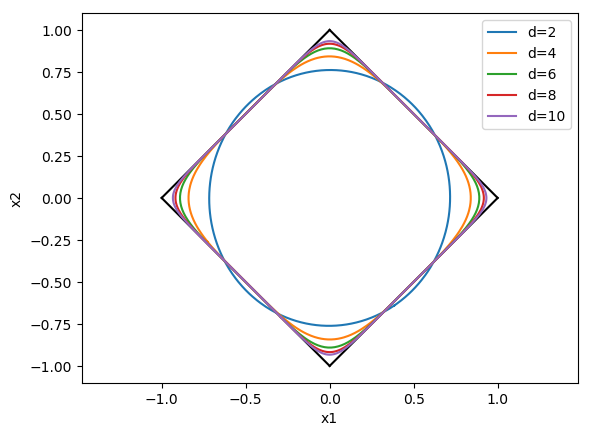

In [60]:

x_m = -1:0.01:1
y_m = -1:0.01:1


z1 = [Float64(( norm([xi;yi],1) )) for xi in x_m, yi in y_m]


for cl in levels(contours(x_m,y_m,z1,[1]))
    lvl = level(cl) # the z-value of this contour level
    for line in lines(cl)
        xs, ys = coordinates(line) # coordinates of this line segment
        #axis[-1.1,1.1,-1.1,1.1]
        plot(xs, ys,color = :black) # pseudo-code; use whatever plotting package you prefer
    end
end


d=0
for sol in pols
    
z2 = [convert(Float64,subs(sol,x =>[xi;yi])) for xi in x_m, yi in y_m]
   
for cl in levels(contours(x_m,y_m,z2,[1]))
    lvl = level(cl) 
    for line in lines(cl)
        d=d+2
        xs, ys = coordinates(line) 
        B=["d=",d]
        plot(xs, ys,label=join(B)) 
    end
end
    
end

axis("equal")

xlabel("x1")
ylabel("x2")
legend(loc = "upper right", fontsize=10);



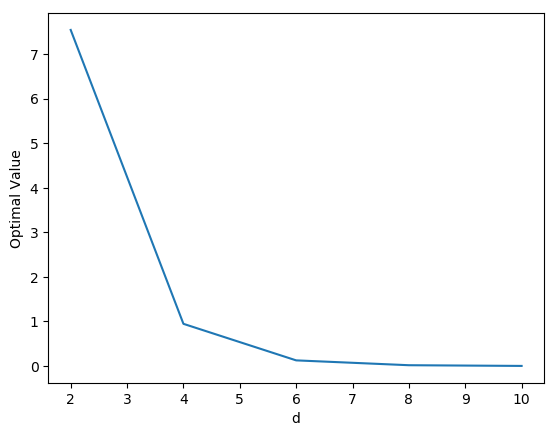

PyObject Text(24.000000000000007, 0.5, 'Optimal Value')

In [67]:
xx = 2:2:10
plot(xx,fo)

xlabel("d")
ylabel("Optimal Value")